In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
import statsmodels.stats.multitest as smm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [4]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [5]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [6]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [7]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1:

In [8]:
groupby_default = data.groupby('default')
data.groupby('default').groups.keys()

dict_keys([0, 1])

In [9]:
data_default0 = groupby_default.get_group(0)['LIMIT_BAL'].values
data_default1 = groupby_default.get_group(1)['LIMIT_BAL'].values

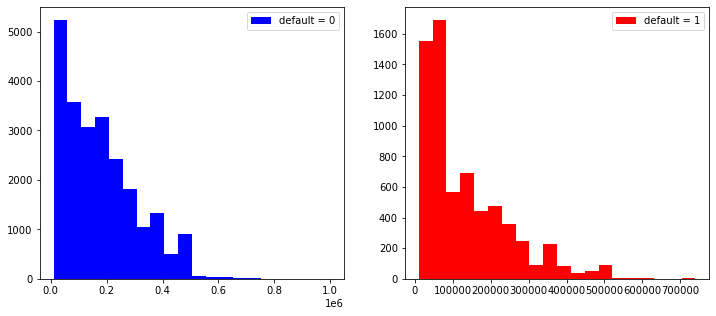

In [10]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_default0, bins = 20, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_default1, bins = 20, color = 'r', label = 'default = 1')
pylab.legend()

pylab.show()

### Судя по графикам, распределение не выглядит нормальным. Проверим наше утверждение, воспользовавшись критерием Шапиро-Уилка

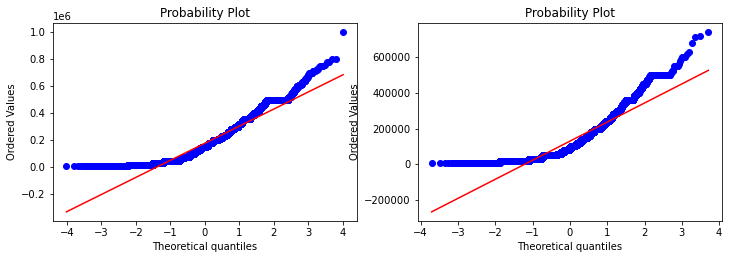

In [11]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data_default0, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data_default1, dist="norm", plot=pylab)
pylab.show()

### Критерий Шапиро-Уилка:

 $H_0\colon$ размеры кредитных лимитов в двух группах распределены нормально
 
 $H_1\colon$ не нормально.

In [12]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_default0))

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_default1))

Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


Гипотезы о нормальности распределения кредитных лимитов в двух группах на уровне значимости 0.05 отвергаются в пользу альтернативы о не нормальности распределений

## а) Для проверки гипотезы о равенстве медианных значений двух выборок воспользуемся Bootstrap

### Интервальная оценка медианы

In [14]:
data_default0_medians = np.median(get_bootstrap_samples(data_default0, 1000), axis = 1)
data_default1_medians = np.median(get_bootstrap_samples(data_default1, 1000), axis = 1)

print("95% доверительный интервал для медианы размеров кредитных лимитов при default = 0: ",  stat_intervals(data_default0_medians, 0.05))
print("95% доверительный интервал для медианы размеров кредитных лимитов при default = 1: ",  stat_intervals(data_default1_medians, 0.05))

95% доверительный интервал для медианы размеров кредитных лимитов при default = 0:  [150000. 150000.]
95% доверительный интервал для медианы размеров кредитных лимитов при default = 1:  [80000. 90000.]


### Точечная оценка разности медиан

In [15]:
print("Разность между медианами :", np.median(data_default0_medians) - np.median(data_default1_medians))

Разность между медианами : 60000.0


### Интервальная оценка разности медиан

In [16]:
print("95% доверительный интервал для разности между медианами",  stat_intervals(data_default0_medians - data_default1_medians, 0.05))

95% доверительный интервал для разности между медианами [60000. 70000.]


## Итоги 1.a

1. Гипотеза о равенстве медианных значений кредитного лимита отвергается на уровне значимости 0.05 и интервальной оценкой медианы и интервальной оценкой разности медиан
2. С практической точки зрения разность между мединами равная 60000 кажется значимой
3. Размер эффекта 10000

## б) Для проверки гипотезы о равенстве распределений воспользуемся ранговым критерием Манна-Уитни

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$


In [17]:
stats.mannwhitneyu(data_default0, data_default1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

## Итог 1.б
Гипотеза о равенстве распределений кредитных лимитов в двух группах на уровне значимости 0.05 отвергается в пользу альтернативы о том, что распределения совпадают с точностью до $\Delta$

# Задание 2

In [18]:
data_default0 = groupby_default.get_group(0)['SEX'].values - 1
data_default1 = groupby_default.get_group(1)['SEX'].values - 1

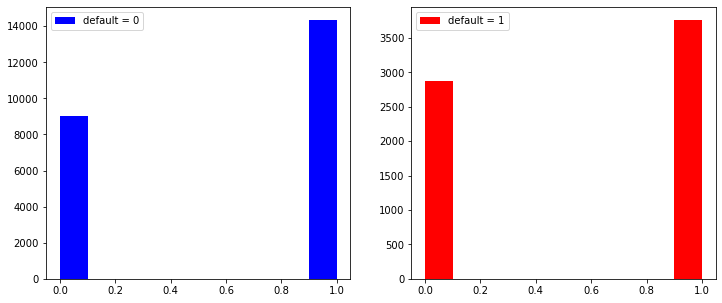

In [19]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_default0, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_default1, color = 'r', label = 'default = 1')
pylab.legend()

pylab.show()

## Для проверки гипотезы о том, что гендерный состав  группы людей вернувших и не вернувших кредит отличается воспользуемся сначала интервальными оценками долей , а затем доверительным интервалом для разности долей для независимых выборок

### Интервальные оценки долей

$H_0\colon$ доли равны

$H_1\colon$ доли не равны

In [20]:
conf_interval_default0 = proportion_confint(sum(data_default0), data_default0.shape[0], method = 'wilson')
conf_interval_default1 = proportion_confint(sum(data_default1), data_default1.shape[0], method = 'wilson')

In [21]:
print('Интервал для default = 0: [%f, %f]' % conf_interval_default0)
print('Интервал для default = 1: [%f, %f]' % conf_interval_default1)

Интервал для default = 0: [0.607890, 0.620373]
Интервал для default = 1: [0.555102, 0.578938]


Гипотеза о равенстве долей отвергается на уровне значимости 0.05, так как интервальные оценки не пересекаются, значит доли не равны, что подтверждает нашу гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

### Доверительный интервал для разности долей (независимые выборки)

$H_0\colon$ доли равны

$H_1\colon$ доли не равны

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [22]:
conf_int = proportions_confint_diff_ind(data_default0, data_default1)
print("Доверительный интервал: [%f, %f]" % conf_int)
print('Размер эффекта', round(conf_int[1] - conf_int[0],4))

Доверительный интервал: [0.033635, 0.060548]
Размер эффекта 0.0269


Гипотеза о равенстве долей отвергается на уровне значимости 0.05, так как доверительный интервал для разности долей не включает 0, значит доли не равны, что подтверждает нашу гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

### Точечная оценка разности долей

In [23]:
print('Разность долей: ', data_default0.mean() - data_default1.mean())

Разность долей:  0.0470915053622627


Результат можно интерпретировать как то, что в среднем женщины  на 5% реже мужчин не возвращают деньги в банк. С практической точки зрения этот результат можно считать значимым, мы можем быть чуть более спокойными за деньги, отданные в долг женщинам

# Задание 3

In [24]:
data_default0 = groupby_default.get_group(0)['EDUCATION'].values
data_default1 = groupby_default.get_group(1)['EDUCATION'].values

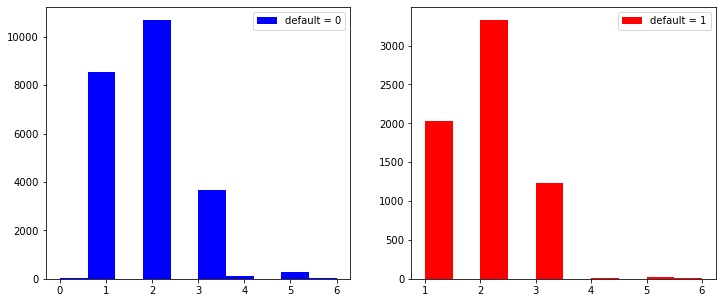

In [25]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_default0, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_default1, color = 'r', label = 'default = 1')
pylab.legend()

pylab.show()

## Для проверки гипотезы о том, что образование не влияет на то, вернет ли человек долг воспользуемся корреляцией Крамера

$H_0\colon$ связь между образованием и тем, вернет ли человек долг есть

$H_1\colon$ связи нет

In [26]:
confusion_matrix = pd.crosstab(data.EDUCATION, data.default)
confusion_matrix

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [27]:
print('Корреляция Крамера: ', round(cramers_corrected_stat(confusion_matrix),4))
print('p-value: ', round(chi2_contingency(confusion_matrix)[1], 4))

Корреляция Крамера:  0.0724
p-value:  0.0


Нулевая гипотеза о связи образования и возврата долга отвергается при очень маленьком значении уровня значимости.

## Cоставим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым и ожидаемым количеством человек

In [28]:
pred = confusion_matrix.sum() / confusion_matrix.sum().sum()
pred

default
0    0.7788
1    0.2212
dtype: float64

In [29]:
confusion_matrix1 =pd.DataFrame(
    {
        0: confusion_matrix[0] - confusion_matrix.sum(axis=1) * pred[0],
        1: confusion_matrix[1] - confusion_matrix.sum(axis=1) * pred[1]
    }
)
confusion_matrix1

,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


**Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?**

-Нормализуем наши отклонения

In [30]:
confusion_matrix2 =pd.DataFrame(
    {
        0: confusion_matrix[0] / confusion_matrix.sum(axis=1) - pred[0],
        1: confusion_matrix[1] / confusion_matrix.sum(axis=1) - pred[1]
    }
)
confusion_matrix2

,0,1
EDUCATION,,
0,0.221200,-0.221200
1,0.028852,-0.028852
2,-0.016149,0.016149
3,-0.030376,0.030376
4,0.164289,-0.164289
5,0.156914,-0.156914
6,0.064337,-0.064337


## Итоги

**Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?**

-Худшим индикатором для возврата долга является наличие образования выпускника школы.
Лучшим - докторская степень

# Задание 4

In [31]:
data_default0 = groupby_default.get_group(0)['MARRIAGE'].values
data_default1 = groupby_default.get_group(1)['MARRIAGE'].values

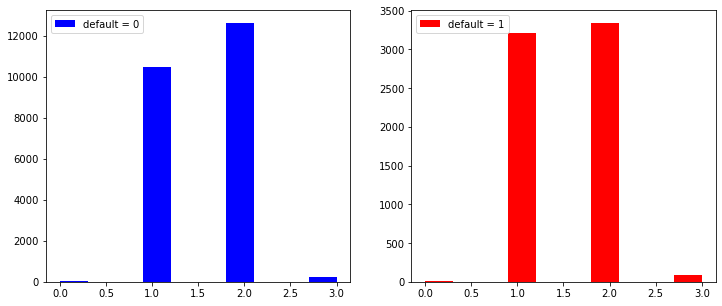

In [32]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_default0, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_default1, color = 'r', label = 'default = 1')
pylab.legend()

pylab.show()

## Для определения связи семейного статуса с индикатором дефолта воспользуемся корреляцией Крамера

$H_0\colon$ связь между семейным статусом и тем, вернет ли человек долг есть

$H_1\colon$ связи нет

In [33]:
confusion_matrix = pd.crosstab(data.default, data.MARRIAGE)
confusion_matrix

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [34]:
print('Корреляция Крамера: ', round(cramers_corrected_stat(confusion_matrix),4))
print('p-value: ', round(chi2_contingency(confusion_matrix)[1], 4))

Корреляция Крамера:  0.033
p-value:  0.0


# Задание 5

In [35]:
data_default0 = groupby_default.get_group(0)['AGE'].values
data_default1 = groupby_default.get_group(1)['AGE'].values

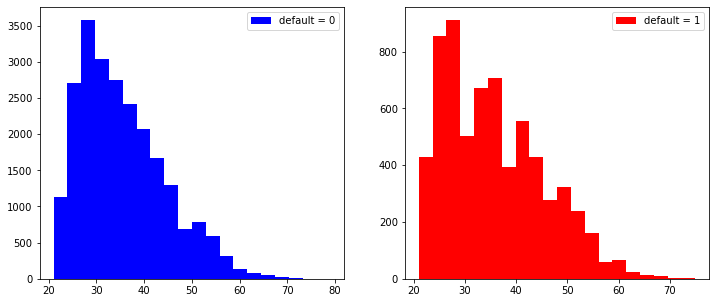

In [36]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data_default0, bins = 20, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data_default1, bins = 20, color = 'r', label = 'default = 1')
pylab.legend()

pylab.show()

### Судя по графикам, распределение не выглядит нормальным. Проверим наше утверждение, воспользовавшись критерием Шапиро-Уилка

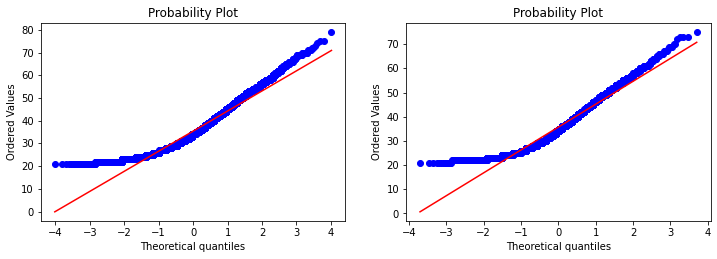

In [37]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data_default0, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data_default1, dist="norm", plot=pylab)
pylab.show()

### Критерий Шапиро-Уилка:

 $H_0\colon$ возраста в двух группах распределены нормально
 
 $H_1\colon$ не нормально.

In [38]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_default0))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_default1))

Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Гипотезы о нормальности распределения возрастов в двух группах на уровне значимости 0.05 отвергаются в пользу альтернативы о не нормальности распределений

## а) Для проверки гипотезы о равенстве медианных значений двух выборок воспользуемся Bootstrap

### Интервальная оценка медианы

In [39]:
data_default0_medians = np.median(get_bootstrap_samples(data_default0, 1000), axis = 1)
data_default1_medians = np.median(get_bootstrap_samples(data_default1, 1000), axis = 1)

print("95% доверительный интервал для медианы возрастов при default = 0: ",  stat_intervals(data_default0_medians, 0.05))
print("95% доверительный интервал для медианы возрастов при default = 1: ",  stat_intervals(data_default1_medians, 0.05))

95% доверительный интервал для медианы возрастов при default = 0:  [34. 34.]
95% доверительный интервал для медианы возрастов при default = 1:  [34. 35.]


### Точечная оценка разности медиан

In [40]:
print("Разность между медианами :", np.median(data_default0_medians) - np.median(data_default1_medians))

Разность между медианами : 0.0


### Интервальная оценка разности медиан

In [41]:
print("95% доверительный интервал для разности между медианами",  stat_intervals(data_default0_medians - data_default1_medians, 0.05))

95% доверительный интервал для разности между медианами [-1.  0.]


## Итоги 1.a

1. Гипотеза о равенстве медианных значений кредитного лимита не отвергается на уровне значимости 0.05 и интервальной оценкой каждой медианы, и интервальной оценкой разности медиан
2. С практической точки зрения разность между мединами равная 0 не кажется значимой
3. Размер эффекта 1

## б) Для проверки гипотезы о равенстве распределений воспользуемся ранговым критерием Манна-Уитни

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [42]:
stats.mannwhitneyu(data_default0, data_default1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

## Итог 1.б
Гипотеза о равенстве распределений кредитных лимитов в двух группах на уровне значимости 0.05 не отвергается